In [99]:
import mne
import sys
import numpy as np
from matplotlib import pyplot as plt
from mne_bids import BIDSPath, read_raw_bids
import os
from joblib import Parallel, delayed
import pandas as pd

In [100]:
# helper functions

def remove_problematic_annotations(bids_root="/Users/jan/Documents/git/ds003846"):
    """Removes problematic columns from participants.tsv to prevent BIDS-related warnings."""
    
    participants_tsv_path = os.path.join(bids_root, "participants.tsv")
    backup_tsv_path = os.path.join(bids_root, "participants_original.tsv")
    if os.path.exists(participants_tsv_path):
        try:
            # Create a backup of the original file
            if not os.path.exists(backup_tsv_path):
                os.rename(participants_tsv_path, backup_tsv_path)
                print(f"Backup created: {backup_tsv_path}")

            # Load the backup file
            participants_df = pd.read_csv(backup_tsv_path, sep='\t')

            # List of problematic columns to remove
            problematic_columns = ['cap_size', 'block_1', 'block_2', 'block_3']
            columns_to_remove = [col for col in problematic_columns if col in participants_df.columns]
            if columns_to_remove:
                print(f"Removing columns {columns_to_remove} from {participants_tsv_path}")
                participants_df = participants_df.drop(columns=columns_to_remove)

            # Save the cleaned file back to the original path
            participants_df.to_csv(participants_tsv_path, sep='\t', index=False)
        except Exception as e:
            print(f"Error processing {participants_tsv_path}: {e}")

def get_available_sessions(bids_root="/Users/jan/Documents/git/ds003846", subject_id="02"):
    """Returns the available sessions for a given subject."""
   
    subject_path = os.path.join(bids_root, f"sub-{subject_id}")
    sessions = []
    if os.path.exists(subject_path):
        for entry in os.listdir(subject_path):
            if entry.startswith("ses-"):
                sessions.append(entry.replace("ses-", ""))
    return sessions


def load_data(bids_root="/Users/jan/Documents/git/ds003846", subject_id="02", session="EMS", show_plots=False):
    """Loads EEG data for the given subject and session."""
    bids_path = BIDSPath(subject=subject_id, task="PredictionError", session=session,
                        datatype='eeg', suffix='eeg',
                        root=bids_root)

    # Read the file
    raw = read_raw_bids(bids_path)
    if show_plots:
        print(raw.info)

    # Plot electrode positions
    #raw.plot_sensors(show_names=True)
    
    # Set Fp1 and Fp2 channel as EOG (electrooculography aka eye movement channel)
    raw.set_channel_types({'Fp1': 'eog', 'Fp2': 'eog'})
    
    return raw


def remove_bad_channels(raw, subject_id, show_plots=False):
    """Remove bad channels from raw data based on their descriptions and inspections."""
    bad_channels_list = {
        2: [4, 16],
        3: [9, 10, 55, 60],
        4: [41],
        5: [1, 33, 41, 42],
        6: [9, 16, 43, 46, 10, 14],
        7: [17, 32, 49],
        8: [41, 42, 62, 63, 9, 17, 55],
        9: [12, 41, 46],
        10: [42, 45, 41, 33, 17],
        11: [22],
        12: [2, 22, 31, 64],
        13: [7, 16, 40, 46, 48],
        14: [2, 3, 7, 16, 28],
        15: [5, 6, 12, 33, 34, 46],
        16: [28, 29, 41, 45, 60],
        17: [1, 2, 3, 22, 28, 36],
        18: [15, 17, 26, 30, 45],
        19: [15, 22, 26, 46, 55, 59, 60],
        20: [2, 8, 11, 36, 62]
    }

    bad_channels = bad_channels_list.get(subject_id, [])
    raw.info['bads'] = [raw.ch_names[ch-1] for ch in bad_channels]
    if show_plots:
        print(raw.info['bads'])


def filtering_referencing(data):
    """Applies filtering and re-referencing to the data."""
    # Remove line noise
    data = data.load_data().copy().notch_filter(freqs=[50, 150])

    # Apply bandpass filter
    data = data.filter(l_freq=0.1, h_freq=125.0)

    # Resample with 250 Hz for less data size
    data = data.copy().resample(sfreq=250)

    # Add reference channels
    data.add_reference_channels(['FCz'])
    
    # Set montage (aka electrode positions)
    montage = mne.channels.make_standard_montage('standard_1020')
    ch_pos = montage.get_positions()['ch_pos']
    # Remove Fp1 and Fp2 from the montage because we get some warning
    ch_pos.pop('Fp1', None)
    ch_pos.pop('Fp2', None)
    # Create a new montage without Fp1 and Fp2
    new_montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame='head')
    data.set_montage(new_montage)

    # Re-reference to average
    data = data.set_eeg_reference('average')
    
    return data


def apply_ica_eyes(data, show_plots=False):
    """Applies ICA to remove eye movements.
    
    Good reference to analyze ICA components: https://labeling.ucsd.edu/tutorial/labels"""
    # Remove artifacts with ICA
    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter="auto")
    ica.fit(data)

    # Check with Fp2 channel as EOG (electrooculography aka eye movement channel)
    eog_inds, eog_scores = ica.find_bads_eog(data, ch_name=['Fp1', 'Fp2'])
    if show_plots:
        ica.plot_scores(eog_scores)
        ica.plot_properties(data, picks=eog_inds)

    if show_plots:
        ica.plot_sources(data, start=60)
        ica.plot_components()
    
    # Remove ICA components
    # Remove the eye movement components
    ica.exclude = eog_inds
    data = ica.apply(data)
    
    return data


def make_erp(data, condition="conflict", show_plots=False):
    evts, evts_dict = mne.events_from_annotations(data)
    #print(evts, evts_dict)
    
    # there are duplicated events with more information as event description
    # unique_times, counts = np.unique(evts[:, 0], return_counts=True)
    # duplicates = unique_times[counts > 1]
    # if len(duplicates) > 0:
    #     print(f"Duplicate event time samples: {duplicates}")
    
    wanted_keys = [e for e in evts_dict.keys() if f"normal_or_conflict:{condition}" in e and "box:touched" in e]
    evts_dict_stim = dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)
    #print(evts_dict_stim)
    
    # Epoching
    epochs = mne.Epochs(data, evts, evts_dict_stim, tmin=-0.3, tmax=0.7, event_repeated='merge', baseline=(-0.3, 0))
    
    # Correct time
    epochs = epochs.load_data().shift_time(-0.063)
    
    # Remove bad epochs
    #reject_criteria = dict(eeg=150e-6, eog=750e-6)  # 150 µV for EEG, 250 µV for EOG
    #epochs.drop_bad(reject=reject_criteria)
    
    epochs.pick(["FCz"])
    reject_criteria = dict(eeg=150e-6) 
    epochs.drop_bad(reject=reject_criteria)
    
    print(f"Number of epochs for condition '{condition}': {len(epochs)}")
    
    #epochs.plot_image(picks="FCz", title=f"Epochs for condition '{condition}' (FCz)")
    # ch = "FCz"  # or any channel name
    # data = epochs.copy().pick(ch).get_data()  # shape: (n_epochs, n_times)
    # times = epochs.times

    # plt.figure(figsize=(10, 5))
    # for ep in data:
    #     plt.plot(times, ep[0, :] * 1e6, color="black", alpha=0.2)

    # plt.title(f"All epochs overlaid – {ch}")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Amplitude (uV)")
    # plt.show()
    
    # Apply final bandpass filter
    #epochs = epochs.copy().filter(l_freq=0.25, h_freq=35.0)
        
    if show_plots:
        epochs.average().copy().pick(['FCz']).plot()
    
    return epochs.average().copy().pick(['FCz'])


def make_erp_plot(normal_data, conflict_data):
    colors = {"Visual": "C0",
        "Vibro": "C2",
        "EMS": "C1"
    }    
    
    mne.viz.plot_compare_evokeds(
        normal_data,
        picks="FCz",
        time_unit="ms",
        colors=colors,
        title="Normal (FCz)"
    )
    
    mne.viz.plot_compare_evokeds(
        conflict_data,
        picks="FCz",
        time_unit="ms",
        colors=colors,
        title="Conflict (FCz)"
    )

In [101]:
remove_problematic_annotations()

Removing columns ['cap_size', 'block_1', 'block_2', 'block_3'] from /Users/jan/Documents/git/ds003846/participants.tsv


# Pipeline

In [102]:
#subjects = ["02"]
subjects = [f"{i:02d}" for i in range(2, 21) if (i != 3)] # exclude subsect 03 for now
print(subjects)
show_intermediate_plots = False

normal_data_all = {}
conflict_data_all = {}


def process_subject(subject_id):
    mne.set_log_level('WARNING')
    
    normal_data = {}
    conflict_data = {}
    sessions = get_available_sessions(subject_id=subject_id)
    print(f"Available sessions for subject {subject_id}: {sessions}")
    
    for session in sessions:
        print(f"Session: {session}")
        # Load data
        data = load_data(subject_id=subject_id, session=session)
        
        # Plot raw data before and after preprocessing
        if show_intermediate_plots:
            data.plot(start=60, duration=12, n_channels=15)
            data.copy().pick(["Cz"]).compute_psd().plot()
        
        # Remove bad channels manually
        remove_bad_channels(data, int(subject_id))

        # Remove bad events manually
        # TBD
        
        # Filtering
        data = filtering_referencing(data)
        
        # Plot better data
        if show_intermediate_plots:
            data.plot(start=60, duration=12, n_channels=15)
            data.copy().pick(["Cz"]).compute_psd().plot()
        
        # Apply ICA
        data = apply_ica_eyes(data)
        
        # Plot after ICA
        if show_intermediate_plots:
            data.plot(start=60, duration=12, n_channels=15)
            data.copy().pick(["Cz"]).compute_psd().plot()
        
        # Apply ASR to remove remaining artifacts
        # TBD
        
        # ERP
        erp_normal = make_erp(data, condition="normal")
        erp_conflict = make_erp(data, condition="conflict")
        
        normal_data[session] = erp_normal
        conflict_data[session] = erp_conflict
        
    # Plot
    if show_intermediate_plots:
        make_erp_plot(normal_data, conflict_data)
    
    return subject_id, normal_data, conflict_data

# parallel processing of each subject using joblib
output = Parallel(n_jobs=4)(delayed(process_subject)(subject_id) for subject_id in subjects)
# output = []
# for subject_id in subjects:
#     result = process_subject(subject_id)
#     output.append(result)

# add results to lists
for subject_id, normal_data, conflict_data in output:
    normal_data_all[subject_id] = normal_data
    conflict_data_all[subject_id] = conflict_data

['02', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Available sessions for subject 02: ['EMS', 'Visual', 'Vibro']
Session: EMS
Available sessions for subject 04: ['Visual', 'Vibro']
Session: Visual
Available sessions for subject 05: ['Visual', 'Vibro']
Session: Visual
Available sessions for subject 06: ['EMS', 'Visual', 'Vibro']
Session: EMS
Number of epochs for condition 'normal': 150
Number of epochs for condition 'conflict': 50
Session: Visual
Number of epochs for condition 'normal': 156
Number of epochs for condition 'conflict': 50
Session: Visual
Number of epochs for condition 'normal': 225
Number of epochs for condition 'conflict': 75
Session: Vibro
Number of epochs for condition 'normal': 225
Number of epochs for condition 'conflict': 75
Session: Vibro
Number of epochs for condition 'normal': 225
Number of epochs for condition 'conflict': 75
Session: Vibro
Number of epochs for condition 'normal': 262
Number of epochs for c

/Users/jan/miniforge3/envs/eeg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Available sessions for subject 09: ['Visual', 'Vibro']
Session: Visual
Number of epochs for condition 'normal': 156
Number of epochs for condition 'conflict': 50
Session: Visual
Number of epochs for condition 'normal': 158
Number of epochs for condition 'conflict': 50
Session: Visual
Number of epochs for condition 'normal': 261
Number of epochs for condition 'conflict': 81
Available sessions for subject 10: ['Visual', 'Vibro']
Session: Visual
Number of epochs for condition 'normal': 225
Number of epochs for condition 'conflict': 75
Session: Vibro
Number of epochs for condition 'normal': 225
Number of epochs for condition 'conflict': 75
Session: Vibro
Number of epochs for condition 'normal': 225
Number of epochs for condition 'conflict': 75
Session: Vibro
Number of epochs for condition 'normal': 225
Number of epochs for condition 'conflict': 75
Session: Vibro
Number of epochs for condition 'normal': 267
Number of epochs for condition 'conflict': 86
Available sessions for subject 11: ['E

02


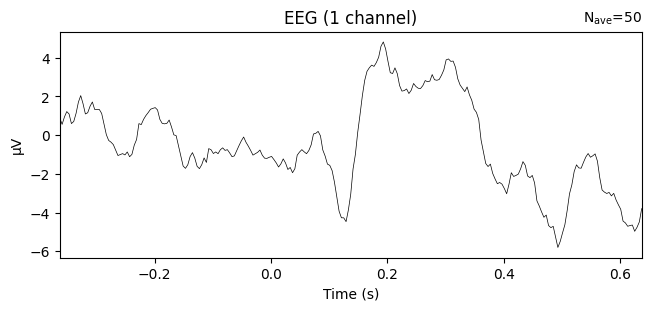

06


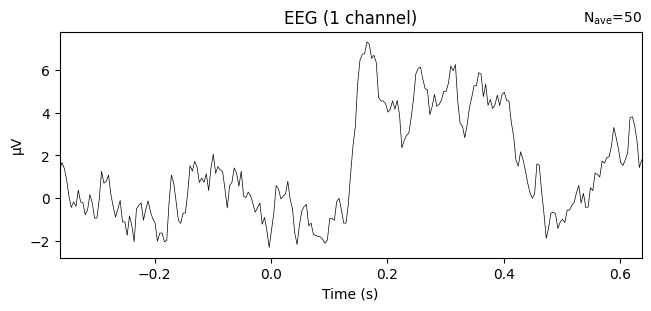

07


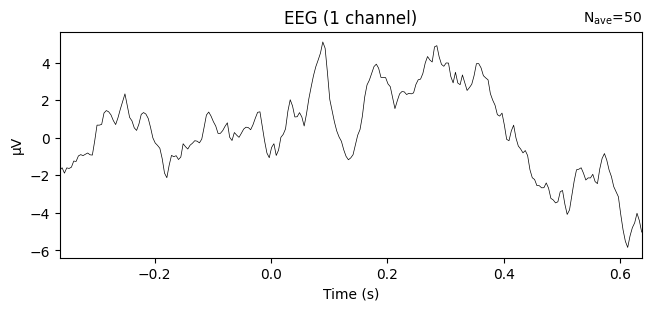

08


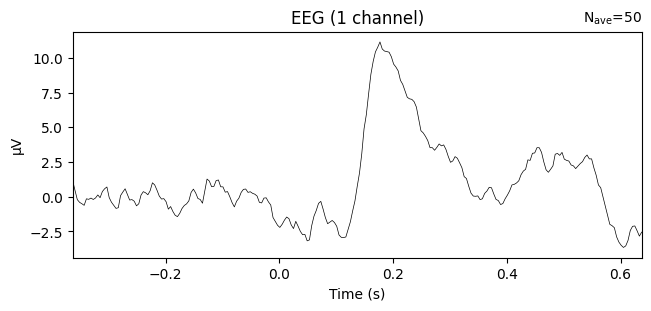

11


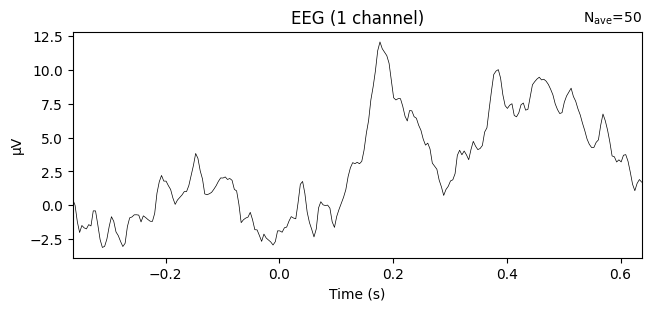

12


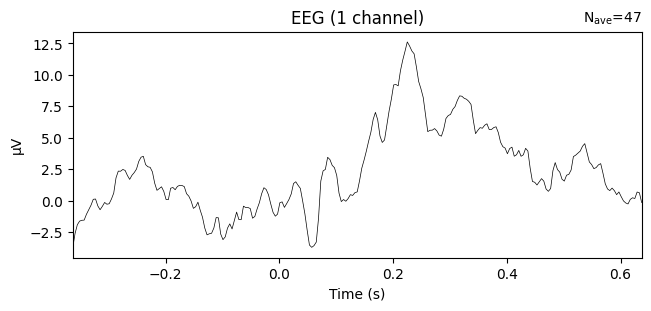

13


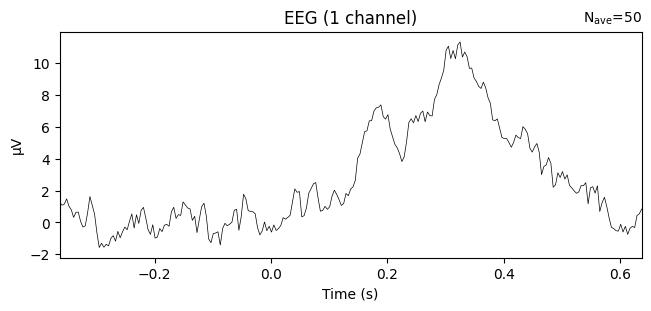

14


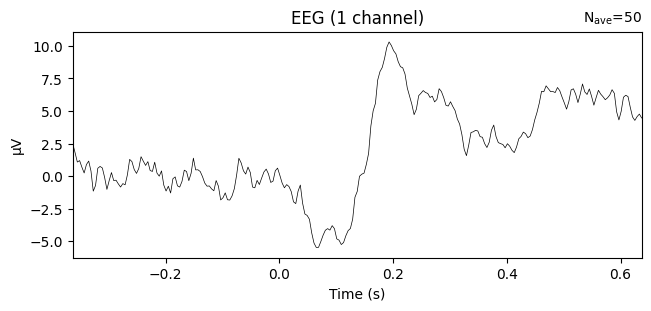

15


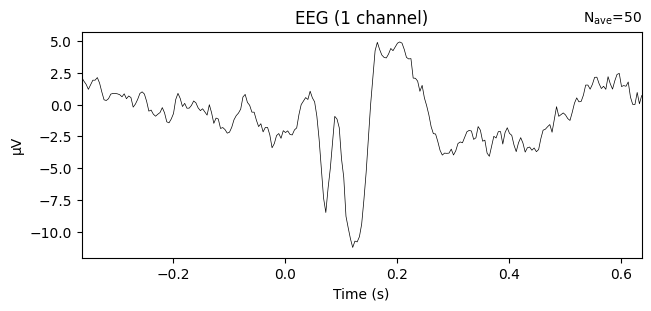

16


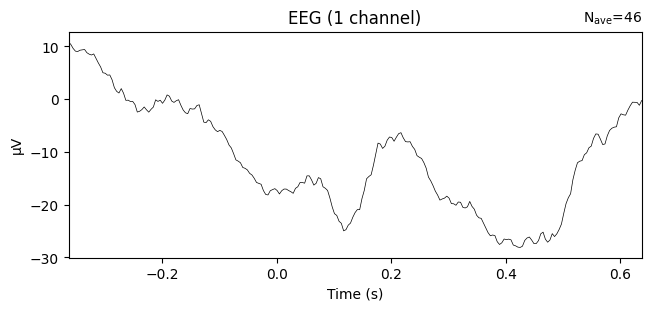

In [109]:
for session in ["EMS"]:
    subjects = conflict_data_all.keys()
    for subject in subjects:
        if session in conflict_data_all[subject]:
            print(subject)
            conflict_data_all[subject][session].plot()

In [104]:
normal_data_all

{'02': {'EMS': <Evoked | '0.01 × box:touched;condition:vibro;emsFeedback:on;reaction_time:0.4476047;trial_nr:47;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.985434;emsCurrent:7;emsWidth:200;pulseCount:12 + 0.01 × box:touched;condition:vibro;emsFeedback:on;reaction_time:0.5249372;trial_nr:63;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.007245;emsCurrent:7;emsWidth:200;pulseCount:12 + 0.01 × box:touched;condition:vibro;emsFeedback:on;reaction_time:0.5366597;trial_nr:58;normal_or_conflict:normal;cube:CubeLeft (UnityEngine.GameObject);isiTime:1.976429;emsCurrent:7;emsWidth:200;pulseCount:12 + 0.01 × box:touched;condition:vibro;emsFeedback:on;reaction_time:0.5591486;trial_nr:21;normal_or_conflict:normal;cube:CubeRight (UnityEngine.GameObject);isiTime:1.702756;emsCurrent:7;emsWidth:200;pulseCount:12 + 0.01 × box:touched;condition:vibro;emsFeedback:on;reaction_time:0.5686879;trial_nr:53;normal_or_conflict:normal;cube:CubeRight (Unit

In [110]:
# exclude participant 16
conflict_data_excluded = {}

for subject, data in conflict_data_all.items():
    if subject != "16":
        conflict_data_excluded[subject] = data

In [111]:
grand_average_normal = {}
grand_average_conflict = {}

# average across subjects and plot
for session in ["Visual", "Vibro", "EMS"]:
    normal_data_all_list = list(normal_data_all.values())
    conflict_data_all_list = list(conflict_data_excluded.values())
    evokeds_normal = [normal_data_all_list[i][session] for i in range(len(normal_data_all_list)) if session in normal_data_all_list[i]]
    evokeds_conflict = [conflict_data_all_list[i][session] for i in range(len(conflict_data_all_list)) if session in conflict_data_all_list[i]] # exclude the last one
    
    print(len(evokeds_normal), len(evokeds_conflict))
    grand_average_normal_session = mne.grand_average(evokeds_normal)
    grand_average_conflict_session = mne.grand_average(evokeds_conflict)
    
    grand_average_normal[session] = grand_average_normal_session
    grand_average_conflict[session] = grand_average_conflict_session
        

18 17
18 17
10 9


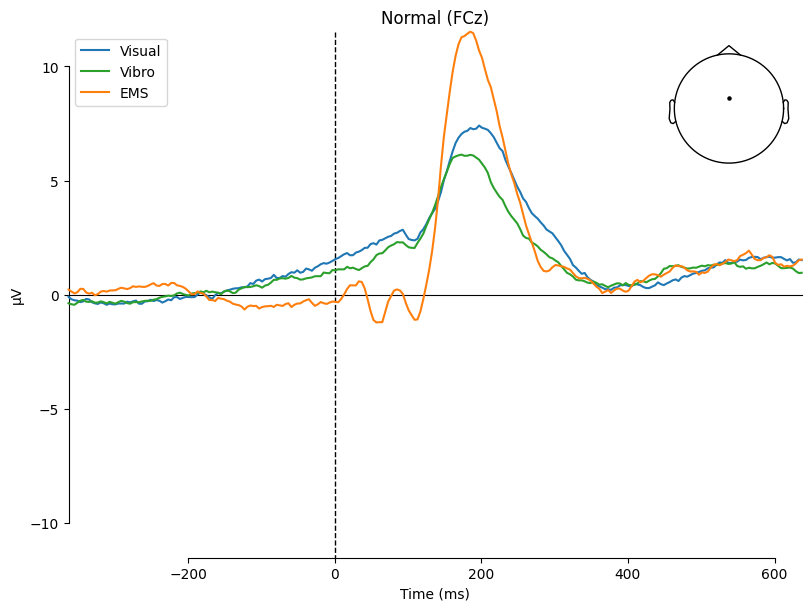

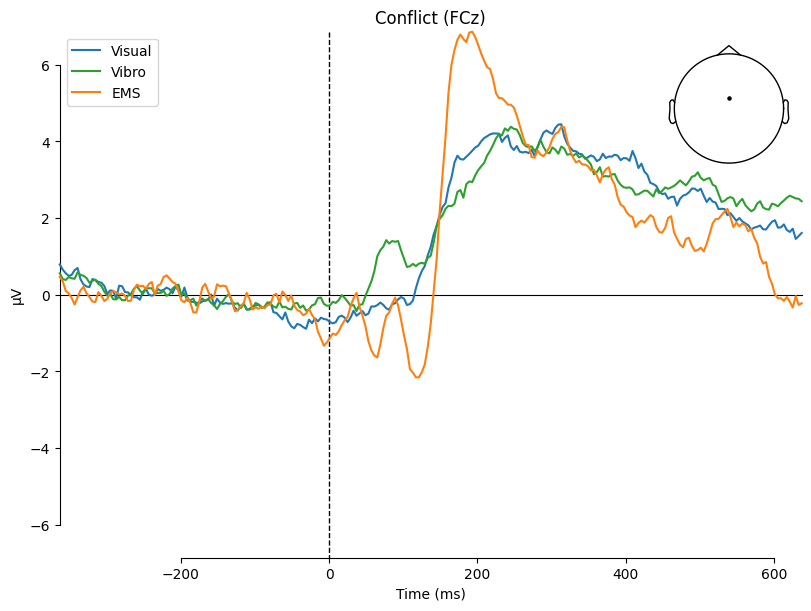

In [112]:
make_erp_plot(grand_average_normal, grand_average_conflict)

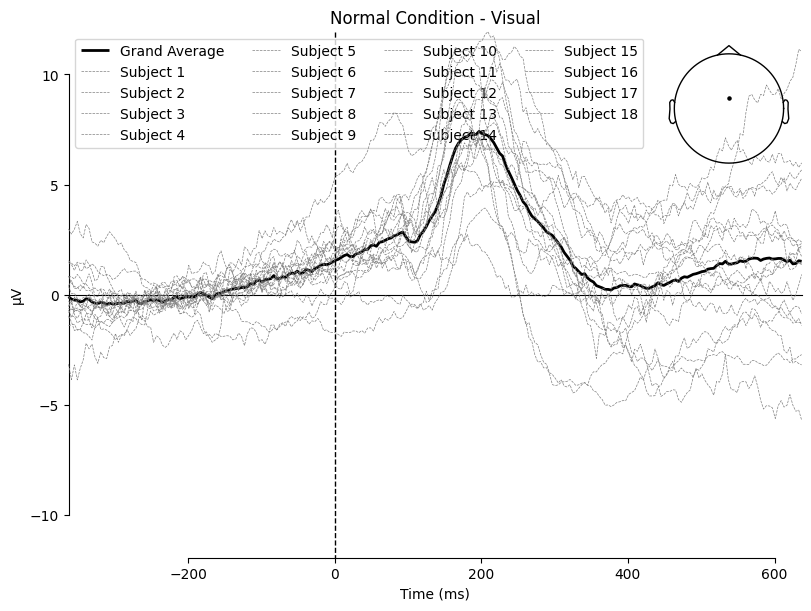

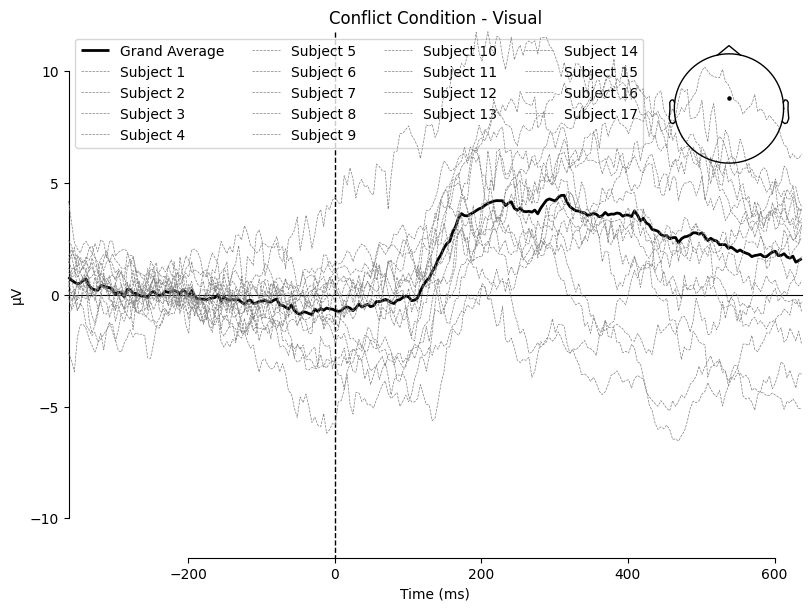

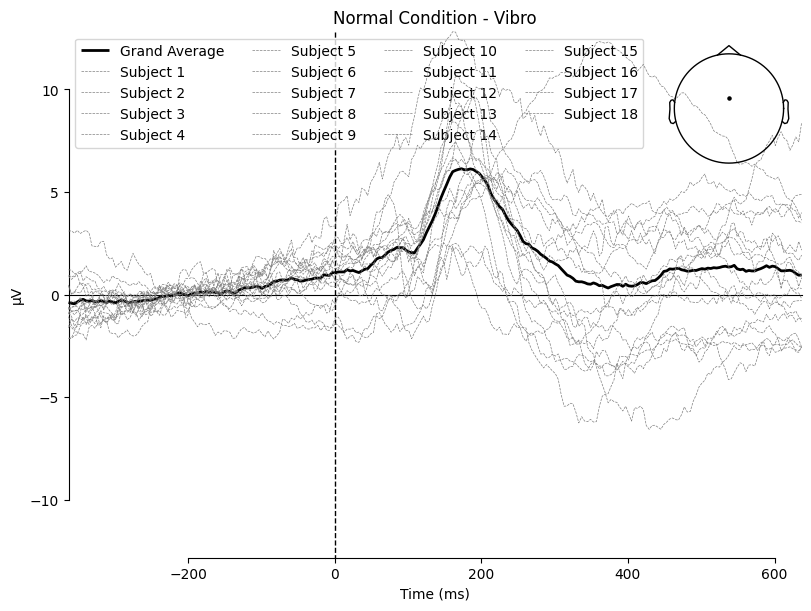

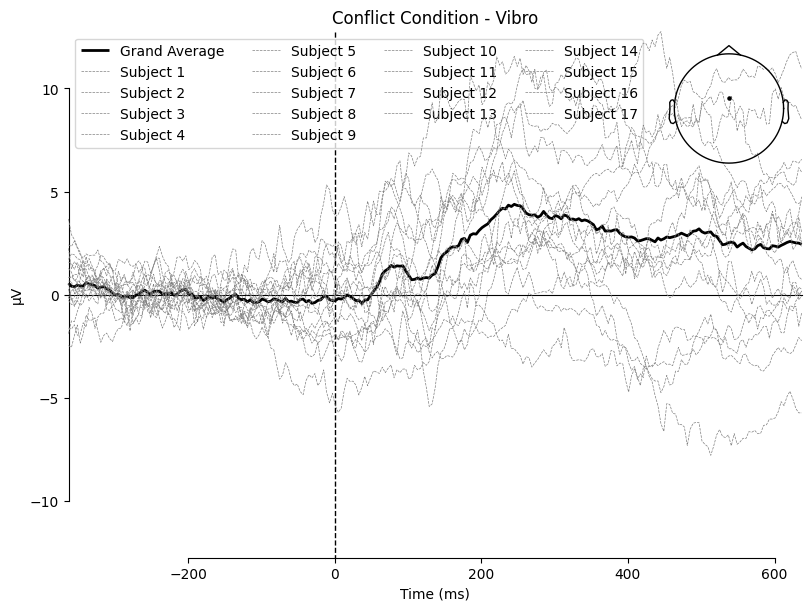

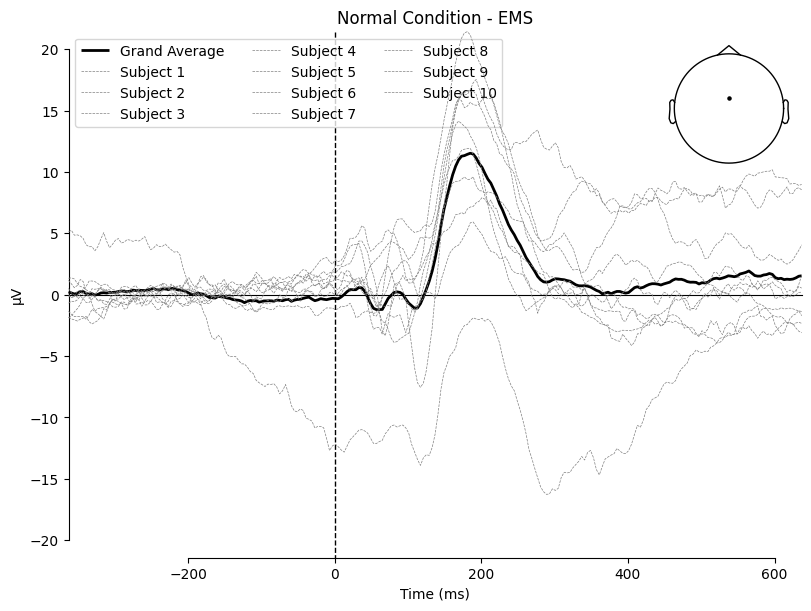

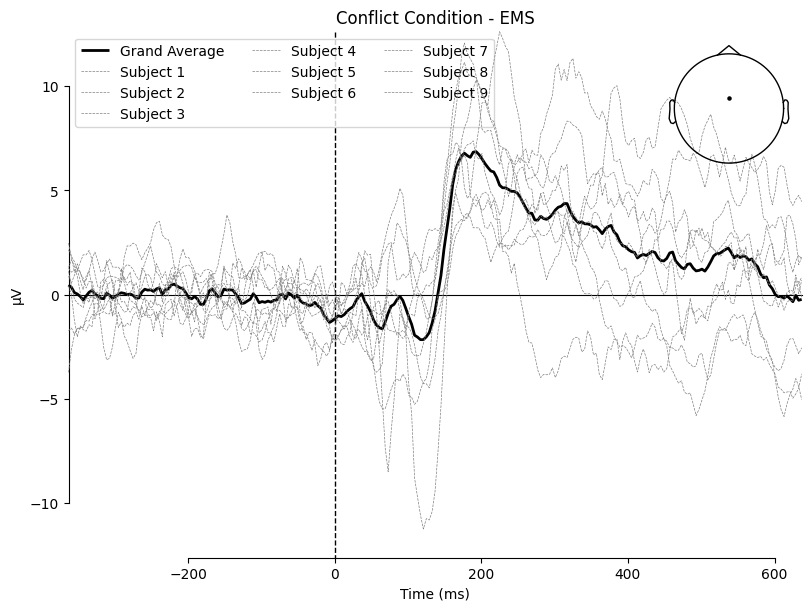

In [113]:
# Add single subjects to the plot with the same color but smaller line width
line_width = 0.5  # Set a smaller line width for individual subjects


for session in ["Visual", "Vibro", "EMS"]:
    normal_data_all_list = list(normal_data_all.values())
    conflict_data_all_list = list(conflict_data_excluded.values())
    evokeds_normal = [normal_data_all_list[i][session] for i in range(len(normal_data_all_list)) if session in normal_data_all_list[i]]
    evokeds_conflict = [conflict_data_all_list[i][session] for i in range(len(conflict_data_all_list)) if session in conflict_data_all_list[i]]
    
    subject_lines_normal = {f"Subject {i+1}": {"linewidth": line_width} for i in range(len(evokeds_normal))}
    subject_lines_conflict = {f"Subject {i+1}": {"linewidth": line_width} for i in range(len(evokeds_conflict))}
    
    # Plot for normal condition
    mne.viz.plot_compare_evokeds(
        {"Grand Average": grand_average_normal[session], 
        **{f"Subject {i+1}": evoked for i, evoked in enumerate(evokeds_normal)}},
        picks="FCz",
        time_unit="ms",
        colors={"Grand Average": "black"},  # Use the same color for all subjects
        linestyles={"Grand Average": "-", **{f"Subject {i+1}": "--" for i in range(len(evokeds_normal))}},
        styles={"Grand Average": {"linewidth": 2}, **subject_lines_normal},
        title=f"Normal Condition - {session}"
    )

    # Plot for conflict condition
    mne.viz.plot_compare_evokeds(
        {"Grand Average": grand_average_conflict[session],
        **{f"Subject {i+1}": evoked for i, evoked in enumerate(evokeds_conflict)}},
        picks="FCz",
        time_unit="ms",
        colors={"Grand Average": "black"},  # Use the same color for all subjects
        linestyles={"Grand Average": "-", **{f"Subject {i+1}": "--" for i in range(len(evokeds_conflict))}},
        styles={"Grand Average": {"linewidth": 2}, **subject_lines_conflict},
        title=f"Conflict Condition - {session}"
    )